<a href="https://colab.research.google.com/github/jhwang1992/KaggleHousePricesPrediction/blob/master/kagglepriceprediction_part3_kerasSequantialModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# update to TensorFlow 2.0

In [0]:
# update to tensorflow 2.0

!pip install --upgrade tensorflow-gpu

In [1]:
# check whether the update is successful

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  import tensorflow.compat.v2 as tf
except Exception:
  pass

tf.enable_v2_behavior()

print(tf.__version__)

2.1.0


# pickle load data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving df_train.pkl to df_train.pkl
Saving df_test.pkl to df_test.pkl


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import make_scorer, mean_squared_error

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import feature_column
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tensorflow import keras

Using TensorFlow backend.


In [0]:
with open('df_train.pkl', 'rb') as f:
    df_train = pickle.load(f)

with open('df_test.pkl', 'rb') as f:
    df_test = pickle.load(f)

In [5]:
print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

df_train shape:  (1450, 76)
df_test shape:  (1459, 75)


# identify numeric and categorical columns

In [6]:
numericColumns = []
categoricalColumns = []

for column in df_train.columns:
  if df_train[column].dtypes==int or df_train[column].dtypes==float:
    numericColumns.append(column)
  else:
    categoricalColumns.append(column)

numericColumns.remove('Id')
numericColumns.remove('SalePrice')

print( len(numericColumns), 'numeric columns: ', numericColumns)
print( len(categoricalColumns), 'categorical columns: ', categoricalColumns)
print( 'ID and SalePrice are seperated')

54 numeric columns:  ['MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
20 categorical columns:  ['MSZoning', 'Street', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtCond',

# data preprocessing using pandas dataframe and scikit-learn

1. impute numeric and categorical columns

2. labelencode string categorical columns

3. split the data into train, validation

4. standardscale the input datasets

In [0]:
# categorical columns fillna
# firstly, to avoid loss nan during NN training
# secondly, to be able to pass to labelencoder

for column in categoricalColumns:
  df_train[column].fillna('missing', inplace = True)
  df_test[column].fillna('missing', inplace = True)

In [0]:
# labelencode string categorical column to integer categorical column
# tf.dataset cannot take in mixed data type, and thus need to change to numeric
# take care of df_test labelencoder transform, there are unique labels not in df_train

import bisect

for column in categoricalColumns:
  le = LabelEncoder()
  le.fit(df_train[column])
  df_train[column] = le.transform(df_train[column])
  le_classes = le.classes_.tolist()
  
  # to handle categorical feature only in testing data
  # handle int and string categorical columns differently
  if type(le_classes[0]) is str:
    df_test[column] = df_test[column].map(lambda s: 'other' if s not in le.classes_ else s)
    bisect.insort_left(le_classes, 'other')
    le.classes_ = le_classes
    df_test[column] = le.transform(df_test[column])
  else:
    df_test[column] = df_test[column].map(lambda s: -1 if s not in le.classes_ else s)
    bisect.insort_left(le_classes, -1)
    le.classes_ = le_classes
    df_test[column] = le.transform(df_test[column])

In [9]:
# split data into train/validation/testing pandas dataframes
# validation dataframe is to be passed into fit()

df_train, df_validation = train_test_split(df_train, test_size=0.2)
print(len(df_train), 'train examples')
print(len(df_validation), 'validation examples')
print(len(df_test), 'test examples')

1160 train examples
290 validation examples
1459 test examples


In [0]:
# numeric columns fillna, to avoid loss nan during NN training

for column in numericColumns:
  df_train[column].fillna(df_train[column].median(), inplace = True)
  df_validation[column].fillna(df_validation[column].median(), inplace = True)
  df_test[column].fillna(df_test[column].median(), inplace = True)

In [0]:
# standardscale the input data

scaler = StandardScaler()
df_train[numericColumns] = scaler.fit_transform(df_train[numericColumns])
df_validation[numericColumns] = scaler.transform(df_validation[numericColumns])
df_test[numericColumns] = scaler.transform(df_test[numericColumns])

# build tf.dataset

tf.dataset defines how data flow into NN

In [0]:
# function to build tf.dataset from pandas dataframes
# three seperate tensorflow.dataset need to be built for train,validation,and testing
# tf.dataset has repeat(equivalent to epoch) and batch_size
# steps = repeat * (total sample number/batch_size)

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('SalePrice')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 32
train_ds = df_to_dataset(df_train, batch_size=batch_size)
val_ds = df_to_dataset(df_validation, shuffle=False, batch_size=batch_size)
df_test['SalePrice'] = 0
test_ds = df_to_dataset(df_test, shuffle=False, batch_size=batch_size)

# define feature_column and feature_layer

feature_column defines how NN interprets the raw input, whether numeric or categorical

feature_layer serves as the first layer of model input

In [0]:
feature_columns = []

for col in numericColumns:
  col = feature_column.numeric_column(col)
  feature_columns.append(col)

for col in categoricalColumns:
  col = feature_column.indicator_column(feature_column.categorical_column_with_vocabulary_list(col,df_train[col].unique()))
  feature_columns.append(col)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# keras sequential model

In [0]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

In [0]:
from tensorflow.keras import optimizers

def build_model():
  model = keras.Sequential([
    feature_layer,
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.optimizers.RMSprop(learning_rate=lr_schedule)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
  return model

model = build_model()

In [16]:
# train the model
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=30)

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Train for 37 steps, validate for 10 steps
Epoch 1/30
37/37 [==============================] - 3s 82ms/step - loss: 138.8817 - mse: 139.1134 - val_loss: 124.1256 - val_mse: 123.4382
Epoch 2/30
37/37 [==============================] - 0s 9ms/step - loss: 106.0034 - mse: 106.3943 - val_loss: 87.8132 - val_mse: 87.9889
Epoch 3/30
37/37 [==============================] - 0s 10ms/step - loss: 65.0454 - mse: 65.5428 - val_loss: 42.1918 - val_mse: 42.9426
Epoch 4/30
37/37 [==============================] - 0s 10ms/step - loss: 24.3923 - mse: 24.6360 - val_loss: 8.7468 - val_mse: 9.2461
Epoch 5/30
37/37 [==============================] - 0s 10ms/step - loss: 3.7073 - mse: 3.6571 - val_loss: 0.9555 - val_mse: 1.0031
Epoch 6/30
37/37 [==================

In [17]:
np.sqrt(0.0456)

0.21354156504062624

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
25,0.019071,0.019071,0.054869,0.053275,25
26,0.018134,0.018134,0.029002,0.031673,26
27,0.016614,0.016614,0.033551,0.036931,27
28,0.017529,0.017529,0.029477,0.032191,28
29,0.016766,0.016766,0.026600,0.029105,29


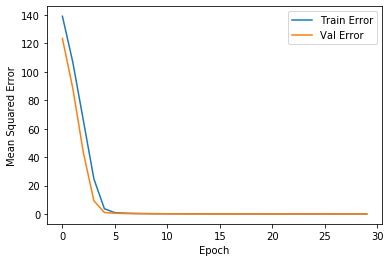

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()

plot_history(history)

# generate prediction output

In [0]:
submission = np.expm1(model.predict(test_ds).flatten())

df = pd.DataFrame(columns = ['Id', 'SalePrice'])
df['Id'] = df_test['Id']
df['SalePrice'] = submission

df.to_csv(r"submission.csv")